# Calculating Metrics to Evaluate VS performance

This notebook applies different metrics to evaluate virtual screening performance. These metrics were reviewed in the previous notebook to the VS scoring results and predictions given by different docking tools.

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
sys.path.append(r'..')

In [2]:
from modules.plotting_metrics import PlotMetric

## Loading Docking Results
First, we have to load the docking results, which were directly obtained from the docking tools. Then, we also have to load the *Ligand Efficiency Scores*, which were calculated in a previous notebook.
> ### Docking score (DkSc)
It is the score directly obtained from the employed docking tool.

> ### Ligand Efficiency (DkLEff)
It corresponds to the quotient between *docking score* and the *number of heavy atoms* of each ligand.

> Interesting paper: [*Beware of ligand efficiency (LE): understanding LE data in modeling structure-activity and structure-economy relationships*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5593805/)

Therefore, we first load the data:

In [3]:
data_dir = '../data/docking_scores'

In [4]:
# CSAR DockingScores
docking_tools_csar = ['AD4_LE', 'AD4_LC', 'VINA', 'VINARDO']
csar_dk_Scores = {dk_tool: pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_{dk_tool}.csv', index_col=0)
                 for dk_tool in docking_tools_csar}
# CSAR Ligand Efficiency
csar_ligEff_Scores = {dk_tool: pd.read_csv(
    F'{data_dir}/vs_dk_CRYS_402_CSAR_{dk_tool}_ligand_Efficiency.csv', index_col=0)
                 for dk_tool in docking_tools_csar}

We also need to define the `y_true_csar` variable, which indicates if a given molecule is truly **active** (=1) or **inactive** (=0) accordingly to the experimental report. We also obtain the *pdb_ids* of all conformations.

In [5]:
# TRUE CSAR VALUES
y_true_csar = np.array(csar_dk_Scores['VINA'].ActiveInactive == "Active", dtype=int)
# PDB_IDS
pdb_ids = csar_dk_Scores['VINA'].drop('ActiveInactive', axis = 1).columns


## Evaluation of VS performance

Then we calculate the available metrics to evaluate the VS performance of the following:

### For CSAR:
1. **We have 402 CDK2 protein conformations**

- **We have 4 docking tools/methods**:
    - *AD4 LC*
    - *AD4 LE*
    - *VINA*
    - *VINARDO*
    
- **We have two different _ranking features_**:
    - *Docking Score*: The scores directly obtained from the each of the docking tools.
    - *Ligand Efficiency*: The quotient between *docking score* and the *number of heavy atoms* of each ligand.
    
- **We evaluate four different metrics**:
    - *ROC-AUC*
    - *BEDROC (alpha = 4)*
    - *Precision and Recall AUC*
    - *Normalized Enrichment Factor AUC*


This means that for each of the protein conformations we have calculated 8 different *rankings*, i.e., we evaluated each conformation with 4 docking tools/methods, following by applying two different *ranking features* (directly using the Dk score or by using Ligand Efficiency). And finally each one of these rankings is evaluated by 4 different metrics.

**The following function performs this task:**

In [6]:
def calc_vs_performance_metrics(ranking_scores_dfs, metrics, docking_tools, 
                                   y_true, bedroc_alpha, column_to_drop):
    results_dic = {}
    for ranking_score in ranking_scores_dfs.keys():
        for metric in metrics.keys():
            for dk_tool in docking_tools:
                rks = ranking_scores_dfs[ranking_score]
                y_preds_dic = rks[dk_tool].drop([column_to_drop], axis = 1).to_dict('list')
                scores = PlotMetric(y_true = y_true, y_pred_dict = y_preds_dic)
                # Now we get the name of the column
                col_name = F'{dk_tool}-{ranking_score}-{metric}'
                metric_to_use = metrics[metric]
                # Calculation of the respective metric
                if metric_to_use == 'bedroc': # If metric is BEDROC parse the alpha argument
                    metric_values = scores.format_metric_results(metric_to_use, 
                                                    alpha = bedroc_alpha).iloc[:,0].values
                else:
                    metric_values = scores.format_metric_results(metric_to_use).iloc[:,0].values
                results_dic[col_name] = metric_values
    # Returns a Dataframe of metric results
    return pd.DataFrame(results_dic, index = pdb_ids)

Then, we apply the fucntion over csar results.

In [7]:
# CSAR metrics results
docking_tools = docking_tools_csar
metrics = {'ROC': 'roc_auc', 'PrcRll': 'pr_auc', 'NEF': 'ref_auc', 'BEDROC': 'bedroc'}
column_to_drop = 'ActiveInactive'
ranking_scores_dfs = {'DkS': csar_dk_Scores, 'DkLEff': csar_ligEff_Scores}
bedroc_alpha = 4
y_true = y_true_csar

csar_dk_402confs_vs_metrics = calc_vs_performance_metrics(ranking_scores_dfs, metrics, docking_tools, 
                                              y_true, bedroc_alpha, column_to_drop)

As a result we got  a new DataFrame of 402 rows and 32 columns (4 dk tools *times* 2 ranking features *times* 4 evaluation metrics).

In [8]:
print('VS Performance in CSAR Dataset')
csar_dk_402confs_vs_metrics.head()

VS Performance in CSAR Dataset


,AD4_LE-DkS-ROC,AD4_LC-DkS-ROC,VINA-DkS-ROC,VINARDO-DkS-ROC,AD4_LE-DkS-PrcRll,AD4_LC-DkS-PrcRll,VINA-DkS-PrcRll,VINARDO-DkS-PrcRll,AD4_LE-DkS-NEF,AD4_LC-DkS-NEF,...,VINA-DkLEff-PrcRll,VINARDO-DkLEff-PrcRll,AD4_LE-DkLEff-NEF,AD4_LC-DkLEff-NEF,VINA-DkLEff-NEF,VINARDO-DkLEff-NEF,AD4_LE-DkLEff-BEDROC,AD4_LC-DkLEff-BEDROC,VINA-DkLEff-BEDROC,VINARDO-DkLEff-BEDROC
1aq1,0.637,0.726,0.575,0.730,0.491,0.554,0.273,0.407,0.691,0.763,...,0.582,0.625,0.856,0.890,0.775,0.826,0.748,0.806,0.682,0.723
1b38,0.642,0.694,0.546,0.678,0.402,0.481,0.278,0.352,0.671,0.726,...,0.541,0.636,0.802,0.808,0.763,0.822,0.690,0.692,0.656,0.720
1b39,0.465,0.525,0.581,0.765,0.209,0.249,0.400,0.553,0.483,0.554,...,0.553,0.729,0.700,0.733,0.786,0.873,0.553,0.573,0.676,0.790
1buh,0.573,0.660,0.535,0.708,0.343,0.475,0.287,0.398,0.616,0.702,...,0.488,0.625,0.810,0.849,0.733,0.811,0.702,0.752,0.620,0.699
1ckp,0.570,0.677,0.571,0.767,0.314,0.472,0.387,0.617,0.600,0.712,...,0.574,0.742,0.770,0.804,0.792,0.905,0.657,0.695,0.689,0.822


In [9]:
csar_dk_402confs_vs_metrics.shape

(402, 32)

### For DUD:
Pretty much like with CSAR, although DUD has been only evaluated with Vinardo.
1. **We have 402 CDK2 protein conformations**

- **We have 1 docking tools/methods**
    
- **We have two different _ranking features_**
    
- **We evaluated four different metrics**

In [10]:
# DUD DockingScores
docking_tools_dud = ['VINARDO']
dud_dk_Scores = {dk_tool: pd.read_csv(F'{data_dir}/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv', index_col=0)
                 for dk_tool in docking_tools_dud}
# DUD Ligand Efficiency
dud_ligEff_Scores = {dk_tool: pd.read_csv(
    F'{data_dir}/vs_dk_CRYS_402_DUD2006_{dk_tool}_ligand_Efficiency.csv', index_col=0)
                 for dk_tool in docking_tools_dud}

**True values of DUD.**

In [11]:
# TRUE DUD VALUES
y_true_dud = np.array(dud_dk_Scores['VINARDO'].Actividad == "Active", dtype=int)

In [12]:
# DUD metrics results
docking_tools = docking_tools_dud
metrics = {'ROC': 'roc_auc', 'PrcRll': 'pr_auc', 'NEF': 'ref_auc', 'BEDROC': 'bedroc'}
column_to_drop = 'Actividad'
ranking_scores_dfs = {'DkS': dud_dk_Scores, 'DkLEff': dud_ligEff_Scores}
bedroc_alpha = 20
y_true = y_true_dud
    
dud_dk_402confs_vs_metrics = calc_vs_performance_metrics(ranking_scores_dfs, metrics, docking_tools, 
                                              y_true, bedroc_alpha, column_to_drop)

In [13]:
dud_dk_402confs_vs_metrics.head()

,VINARDO-DkS-ROC,VINARDO-DkS-PrcRll,VINARDO-DkS-NEF,VINARDO-DkS-BEDROC,VINARDO-DkLEff-ROC,VINARDO-DkLEff-PrcRll,VINARDO-DkLEff-NEF,VINARDO-DkLEff-BEDROC
1aq1,0.624,0.089,0.623,0.253,0.684,0.148,0.683,0.330
1b38,0.566,0.179,0.572,0.294,0.661,0.205,0.664,0.358
1b39,0.603,0.194,0.608,0.348,0.700,0.190,0.702,0.357
1buh,0.470,0.036,0.470,0.087,0.572,0.049,0.571,0.118
1ckp,0.639,0.132,0.639,0.330,0.733,0.147,0.730,0.348


## For DEKOIS 2.0:
The same as with DUD:
1. **We have 402 CDK2 protein conformations**

- **We have 1 docking tools/methods**
    
- **We have two different _ranking features_**
    
- **We evaluated four different metrics**

In [14]:
# DEKOIS DockingScores
docking_tools_dekois = ['VINA', 'VINARDO']
dekois_dk_Scores = {dk_tool: pd.read_csv(
    F'{data_dir}/vs_dk_CRYS_402_DEKOIS_{dk_tool}_docking_score.csv', index_col=0)
                 for dk_tool in docking_tools_dekois}
# DEKOIS Ligand Efficiency
dekois_ligEff_Scores = {dk_tool: pd.read_csv(
    F'{data_dir}/vs_dk_CRYS_402_DEKOIS2_{dk_tool}_ligand_Efficiency.csv', index_col=0)
                 for dk_tool in docking_tools_dekois}

#### True values of DEKOIS2.0

In [15]:
# TRUE DEKOIS2.0 VALUES
y_true_dekois = np.array(dekois_dk_Scores['VINARDO'].Actividad == "Active", dtype=int)

In [16]:
# DUD metrics results
docking_tools = docking_tools_dekois
metrics = {'ROC': 'roc_auc', 'PrcRll': 'pr_auc', 'NEF': 'ref_auc', 'BEDROC': 'bedroc'}
column_to_drop = 'Actividad'
ranking_scores_dfs = {'DkS': dekois_dk_Scores, 'DkLEff': dekois_ligEff_Scores}
bedroc_alpha = 20
y_true = y_true_dekois
    
dekois_dk_402confs_vs_metrics = calc_vs_performance_metrics(ranking_scores_dfs, metrics, docking_tools, 
                                              y_true, bedroc_alpha, column_to_drop)

In [17]:
dekois_dk_402confs_vs_metrics.head()

,VINA-DkS-ROC,VINARDO-DkS-ROC,VINA-DkS-PrcRll,VINARDO-DkS-PrcRll,VINA-DkS-NEF,VINARDO-DkS-NEF,VINA-DkS-BEDROC,VINARDO-DkS-BEDROC,VINA-DkLEff-ROC,VINARDO-DkLEff-ROC,VINA-DkLEff-PrcRll,VINARDO-DkLEff-PrcRll,VINA-DkLEff-NEF,VINARDO-DkLEff-NEF,VINA-DkLEff-BEDROC,VINARDO-DkLEff-BEDROC
1aq1,0.603,0.729,0.079,0.076,0.601,0.725,0.168,0.201,0.622,0.699,0.046,0.059,0.620,0.695,0.087,0.147
1b38,0.626,0.676,0.044,0.051,0.622,0.669,0.079,0.090,0.597,0.662,0.045,0.056,0.597,0.658,0.091,0.132
1b39,0.627,0.691,0.054,0.060,0.623,0.686,0.149,0.125,0.599,0.666,0.043,0.053,0.597,0.661,0.088,0.113
1buh,0.628,0.688,0.061,0.055,0.631,0.682,0.147,0.120,0.599,0.650,0.041,0.053,0.596,0.646,0.082,0.135
1ckp,0.594,0.720,0.049,0.069,0.593,0.714,0.133,0.164,0.587,0.687,0.042,0.059,0.586,0.682,0.086,0.138


# Visualization

The following functions will be used to plot the results previously obtained.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
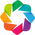

In [18]:
import holoviews as hv
from holoviews import dim
from bokeh.io import show
hv.extension('bokeh')

In [19]:
from auxiliar_plot_swarm import boxplot_metrics, plot_swarm_pair

In [20]:
?boxplot_metrics

In [21]:
a = csar_dk_402confs_vs_metrics.filter(like='VINARDO')
b = dud_dk_402confs_vs_metrics.filter(like='VINARDO')
c = dekois_dk_402confs_vs_metrics.filter(like='VINARDO')
# Rename columns
a.columns = [c.replace('VINARDO', 'CSAR')  for c in a.columns]
b.columns = [c.replace('VINARDO', 'DUD')  for c in b.columns]
c.columns = [c.replace('VINARDO', 'DEKOIS2')  for c in c.columns]
# Merging columns
vinardo_metrics_3_db = pd.concat([a, b, c], axis = 1)

### Boxplos comparing all Molecular Libraries

In [22]:
vinardo_metrics_3_db

,CSAR-DkS-ROC,CSAR-DkS-PrcRll,CSAR-DkS-NEF,CSAR-DkS-BEDROC,CSAR-DkLEff-ROC,CSAR-DkLEff-PrcRll,CSAR-DkLEff-NEF,CSAR-DkLEff-BEDROC,DUD-DkS-ROC,DUD-DkS-PrcRll,...,DUD-DkLEff-NEF,DUD-DkLEff-BEDROC,DEKOIS2-DkS-ROC,DEKOIS2-DkS-PrcRll,DEKOIS2-DkS-NEF,DEKOIS2-DkS-BEDROC,DEKOIS2-DkLEff-ROC,DEKOIS2-DkLEff-PrcRll,DEKOIS2-DkLEff-NEF,DEKOIS2-DkLEff-BEDROC
1aq1,0.730,0.407,0.737,0.575,0.805,0.625,0.826,0.723,0.624,0.089,...,0.683,0.330,0.729,0.076,0.725,0.201,0.699,0.059,0.695,0.147
1b38,0.678,0.352,0.676,0.535,0.799,0.636,0.822,0.720,0.566,0.179,...,0.664,0.358,0.676,0.051,0.669,0.090,0.662,0.056,0.658,0.132
1b39,0.765,0.553,0.783,0.681,0.850,0.729,0.873,0.790,0.603,0.194,...,0.702,0.357,0.691,0.060,0.686,0.125,0.666,0.053,0.661,0.113
1buh,0.708,0.398,0.707,0.540,0.781,0.625,0.811,0.699,0.470,0.036,...,0.571,0.118,0.688,0.055,0.682,0.120,0.650,0.053,0.646,0.135
1ckp,0.767,0.617,0.794,0.708,0.900,0.742,0.905,0.822,0.639,0.132,...,0.730,0.348,0.720,0.069,0.714,0.164,0.687,0.059,0.682,0.138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6q4g,0.630,0.357,0.646,0.503,0.800,0.566,0.806,0.694,0.443,0.040,...,0.521,0.105,0.668,0.051,0.661,0.097,0.653,0.051,0.649,0.114
6q4h,0.534,0.232,0.547,0.317,0.717,0.470,0.736,0.571,0.516,0.063,...,0.630,0.263,0.674,0.053,0.670,0.121,0.668,0.053,0.664,0.105
6q4i,0.644,0.309,0.639,0.482,0.794,0.563,0.804,0.688,0.446,0.056,...,0.582,0.230,0.698,0.068,0.691,0.173,0.674,0.055,0.669,0.116
6q4j,0.558,0.257,0.569,0.396,0.709,0.556,0.752,0.626,0.548,0.052,...,0.653,0.308,0.730,0.062,0.723,0.127,0.680,0.064,0.677,0.164


#### Create a colormap to preserve the color keys

In [23]:
from matplotlib.colors import LinearSegmentedColormap, rgb2hex
from matplotlib import cm
import seaborn as sns
palette = sns.color_palette('Set3', 4)
palette = palette[1:]
cmap = LinearSegmentedColormap.from_list('boxpal', palette)
# colors = [rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

### Comparison between molecular libraries (only docking Score)

In [24]:
fig = boxplot_metrics(data = vinardo_metrics_3_db.filter(like='DkS'), 
                      invert_xaxis = False, palette=cmap,
                      title = "CSAR vs 402 CDK2 conformations")
show(fig)

### Comparison between molecular libraries (DkS and DkLeff)

In [25]:
fig = boxplot_metrics(data = vinardo_metrics_3_db, 
                      invert_xaxis = False, palette=cmap,
                      title = "CSAR vs 402 CDK2 conformations")
show(fig)

## CSAR Databases vs 402 CDK2 conformations

In [26]:
f = boxplot_metrics(data = csar_dk_402confs_vs_metrics, 
                    title = "CSAR vs 402 CDK2 conformations")
show(f)

In [27]:
f = boxplot_metrics(data = dud_dk_402confs_vs_metrics, color_by= 'Ranking',
                    title = "DUD vs 402 CDK2 conformations: Vinardo")
show(f)

In [28]:
f = boxplot_metrics(data = dekois_dk_402confs_vs_metrics, color_by= 'Ranking',
                    title = "DEKOIS2.0 vs 402 CDK2 conformations: Vinardo")
show(f)

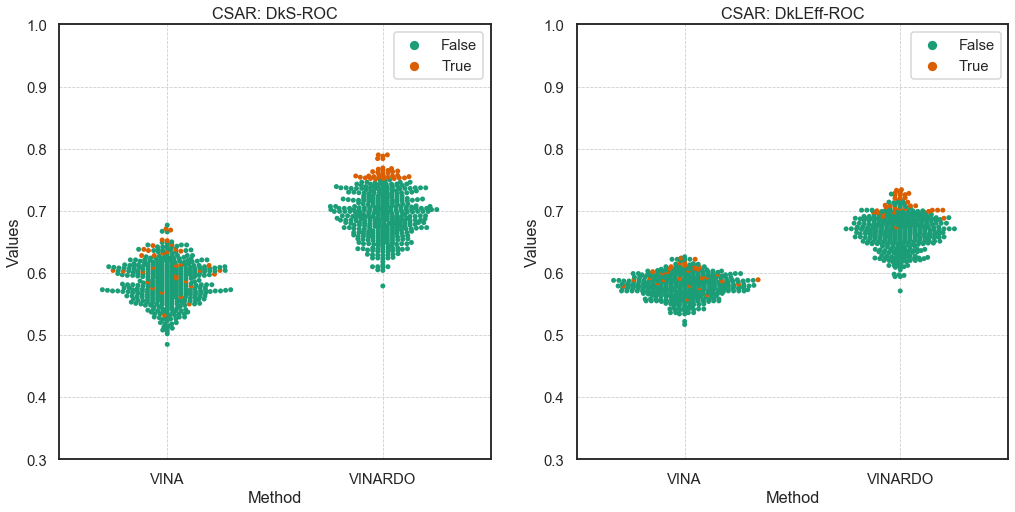

In [29]:
df = dekois_dk_402confs_vs_metrics
hue = df['VINARDO-DkS-ROC'] > 0.75
plot_swarm_pair(df, title='CSAR', metric='ROC', hue = hue,
                alpha = 1)

## ROC-AUC and Ligand Efficiency

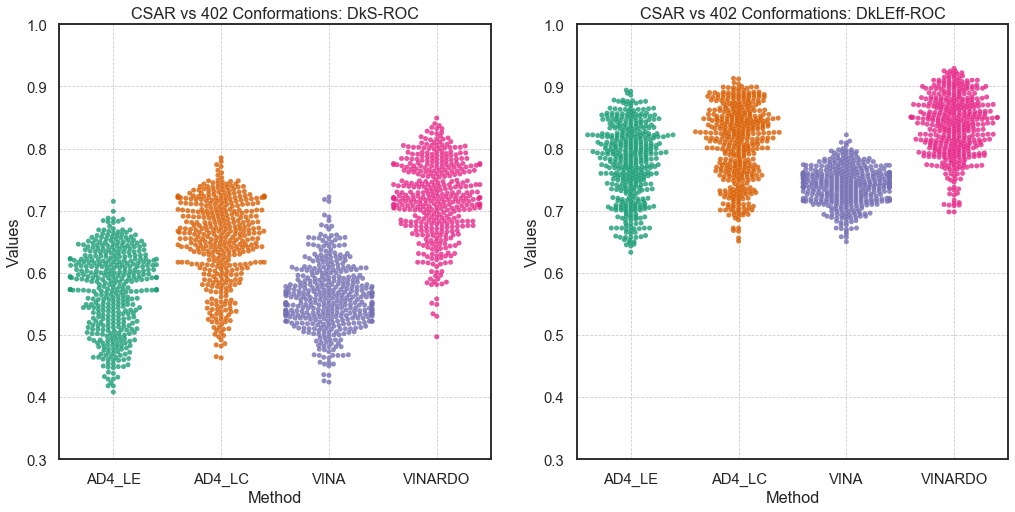

In [30]:
df = csar_dk_402confs_vs_metrics
hue = df['VINARDO-DkS-ROC'] > 0.8
plot_swarm_pair(df, title='CSAR vs 402 Conformations', metric='ROC', alpha = 0.8)

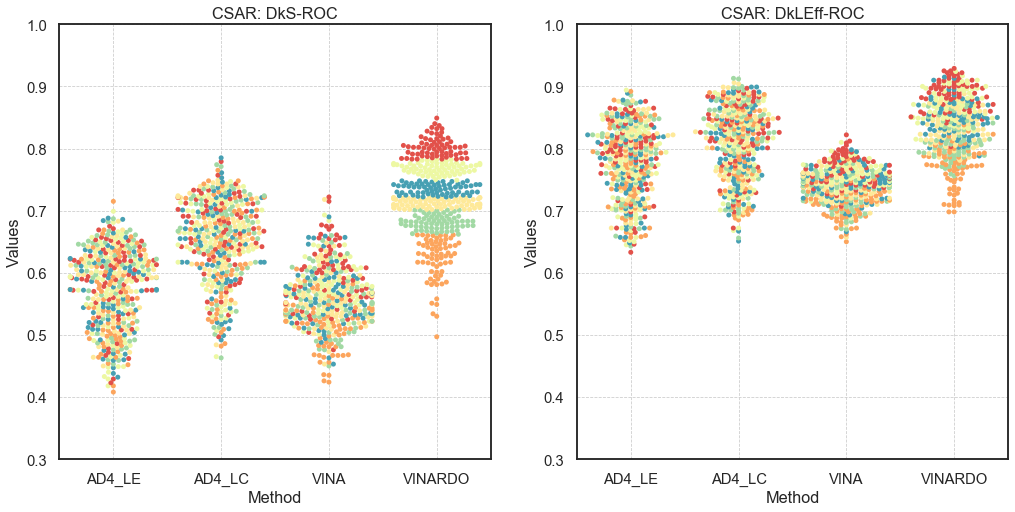

In [31]:
df = csar_dk_402confs_vs_metrics
hue = pd.qcut(df['VINARDO-DkS-ROC'], 6)
plot_swarm_pair(df, title='CSAR', metric='ROC', hue = hue, 
                legend = False, cmap = 'Spectral_r', alpha = 1)

## Correlation between Vinardo DkSc and Vinardo DkEff in CSAR and DUD databases

In [32]:
from holoviews.operation import gridmatrix
from holoviews import opts

df_1 = csar_dk_402confs_vs_metrics.filter(regex='-ROC', axis = 1).filter(regex='VINARDO', axis = 1)
df_1.columns = ['CSAR_DkS_ROC', 'CSAR_DkLEff_ROC']

df_2 = dud_dk_402confs_vs_metrics.filter(regex='-ROC', axis = 1).filter(regex='VINARDO', axis = 1)
df_2.columns = ['DUD_DkS_ROC', 'DUD_DkLEff_ROC']

df = pd.concat([df_1, df_2], axis = 1)
ds = hv.Dataset(df)

density_grid = gridmatrix(ds, diagonal_type=hv.Distribution, chart_type=hv.Bivariate)
point_grid = gridmatrix(ds, chart_type=hv.Points)

(density_grid * point_grid).opts(
    opts.Bivariate(bandwidth=0.5, cmap='Blues'), 
    opts.Points(size=2, tools=['box_select'])).options(width=1000, height=1000)

:GridMatrix   [X,Y]
   :Overlay
      .Distribution.I :Distribution   [DUD_DkS_ROC]   (Density)
      .Histogram.I    :Histogram   [DUD_DkS_ROC]   (DUD_DkS_ROC_frequency)

In [33]:
corr_pearson_vrd = df.corr(method='pearson')
corr_pearson_vrd

,CSAR_DkS_ROC,CSAR_DkLEff_ROC,DUD_DkS_ROC,DUD_DkLEff_ROC
CSAR_DkS_ROC,1.000000,0.853157,0.564898,0.606934
CSAR_DkLEff_ROC,0.853157,1.000000,0.535789,0.611338
DUD_DkS_ROC,0.564898,0.535789,1.000000,0.949575
DUD_DkLEff_ROC,0.606934,0.611338,0.949575,1.000000


In [34]:
corr_spearman_vrd = df.corr(method='spearman')
corr_spearman_vrd

,CSAR_DkS_ROC,CSAR_DkLEff_ROC,DUD_DkS_ROC,DUD_DkLEff_ROC
CSAR_DkS_ROC,1.000000,0.832582,0.572037,0.623494
CSAR_DkLEff_ROC,0.832582,1.000000,0.543320,0.650147
DUD_DkS_ROC,0.572037,0.543320,1.000000,0.915825
DUD_DkLEff_ROC,0.623494,0.650147,0.915825,1.000000
